Section 1: Import Required Libraries

(Introduce libraries needed for ML, data handling, and plotting.)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import preprocessing layers individually
from tensorflow.keras.layers import Normalization, Rescaling, TextVectorization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import datetime
from google.colab import files

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

Section 2: Upload and Load Dataset

(Show how to bring external data into Python and inspect it.)

In [16]:
uploaded = files.upload()  # Upload 'thermal_data_100.csv'


Saving thermal_data_100.csv to thermal_data_100 (1).csv


In [17]:
data = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

Section 3: Define Inputs and Outputs

(Explain input features and output labels for supervised ML.)

In [18]:
# Define input and output columns
input_cols = ["T0", "T1", "T2", "T3", "T4", "T5"]
output_cols = ["q", "T1*", "T2*", "T3*", "T4*"]

Section 4: Split Data into Training and Test Sets

(Introduce train/test split to evaluate model performance.)

In [19]:
train_dataset = data.sample(frac=0.8, random_state=42)
test_dataset = data.drop(train_dataset.index)

Section 5: Normalize Data

(Explain why normalization is important for neural networks.)

In [20]:
# Training stats (for normalization)
train_stats = train_dataset[input_cols].describe().transpose()

# Normalize function
def normalize(df):
    return (df - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset[input_cols])
normed_test_data = normalize(test_dataset[input_cols])

# Separate labels (outputs)
train_labels = train_dataset[output_cols]
test_labels = test_dataset[output_cols]

# Display normalized data
print("Normalized train data (first 5 rows):")
print(normed_train_data.head())
print("\nNormalized test data (first 5 rows):")
print(normed_test_data.head())

Normalized train data (first 5 rows):
          T0        T1        T2        T3        T4        T5
83 -1.484795 -1.479473 -1.464805 -1.470403 -1.477786 -1.474696
53 -0.058715 -0.056723 -0.075161 -0.073923 -0.071393 -0.076762
70  1.285299  1.287747  1.296013  1.300049  1.306125  1.301035
45 -0.425447 -0.421499 -0.440060 -0.427810 -0.408476 -0.414153
44 -0.068504 -0.071634 -0.078104 -0.084607 -0.095690 -0.086801

Normalized test data (first 5 rows):
          T0        T1        T2        T3        T4        T5
1   0.305988  0.320008  0.308706  0.324073  0.346100  0.325411
2   0.605269  0.619909  0.610583  0.620630  0.634990  0.627307
14  0.188258  0.189222  0.181581  0.181166  0.180514  0.168227
20  0.054053  0.060838  0.036587  0.049846  0.069062  0.050934
21  0.731338  0.754558  0.719676  0.746577  0.785096  0.760312


Section 6: Build the Model

(Explain neural network architecture: layers, activation functions, inputs, and outputs.)

In [21]:
num_outputs = 5

baseline_model = keras.Sequential([
    layers.Input(shape=(len(input_cols),)),  # Use Input layer instead of input_shape in Dense
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_outputs)  # 5 outputs
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
baseline_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,093 (35.52 KB)

 Trainable params: 9,093 (35.52 KB)

 Non-trainable params: 0 (0.00 B)

Section 7: Define Callback and Training Parameters

(Show how callbacks work and why epochs matter.)

In [22]:
# Callback to print progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

Section 8: Example Prediction Before Training

(Explain how model predictions work before any training.)

In [23]:
example_batch = normed_train_data[:5].values
example_result = baseline_model.predict(example_batch)
print("Example predictions (q, T1*, T2*, T3*, T4*):")
print(example_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Example predictions (q, T1*, T2*, T3*, T4*):
[[-0.287 -0.051 -0.705 -0.366 -0.048]
 [-0.014  0.    -0.032 -0.018 -0.001]
 [-0.311  0.433 -0.126 -0.271  0.13 ]
 [-0.083 -0.016 -0.2   -0.105 -0.012]
 [-0.016  0.    -0.038 -0.021 -0.002]]


Section 9: Setup TensorBoard

(Introduce monitoring training metrics interactively.)

In [24]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Section 10: Train the Model

(Explain model fitting, validation split, and callbacks.)

In [25]:
history = baseline_model.fit(
    normed_train_data.values, train_labels.values,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[tensorboard_callback, PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Section 11: Plot Training History

(Show how to visualize learning curves (MAE, MSE) to understand model performance.)

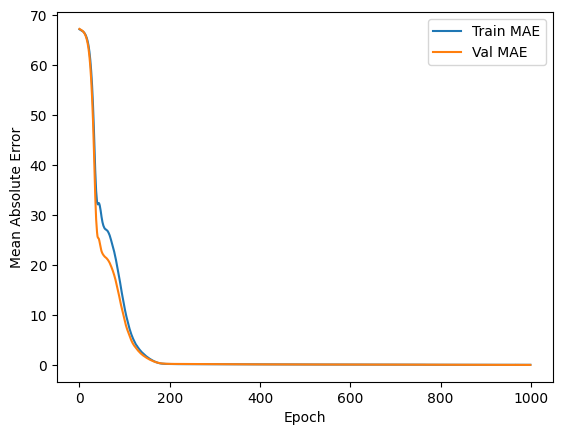

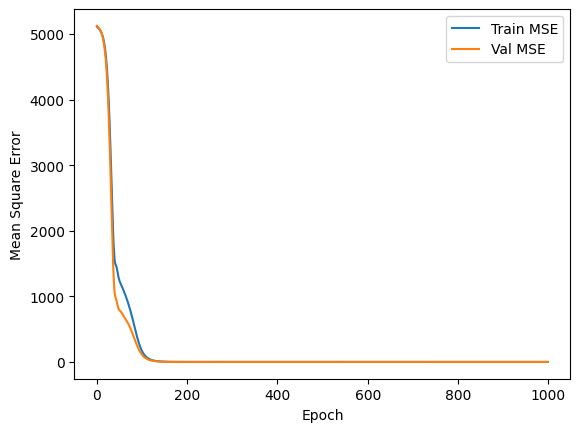

In [26]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # MAE
    plt.figure()
    plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    # MSE
    plt.figure()
    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

plot_history(history)

Section 12: Test Predictions and Scatter Plot

(Visualize model predictions vs actual values.)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


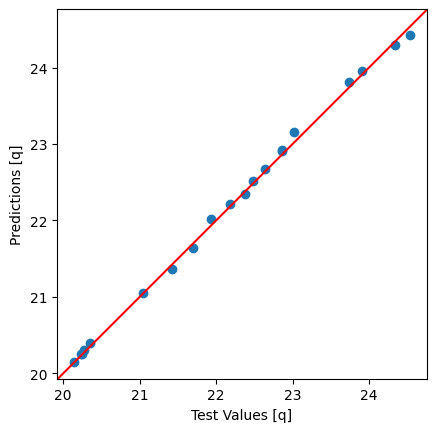

In [ ]:
baseline_test_predictions = baseline_model.predict(normed_test_data.values)

plt.figure()
plt.scatter(test_labels['q'], baseline_test_predictions[:, 0])
plt.xlabel("Test Values [q]")
plt.ylabel("Predictions [q]")
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 100], [-100, 100], 'r')
plt.show()

Section 13: Prediction Error Histograms

(Teach students to check model errors for each output.)

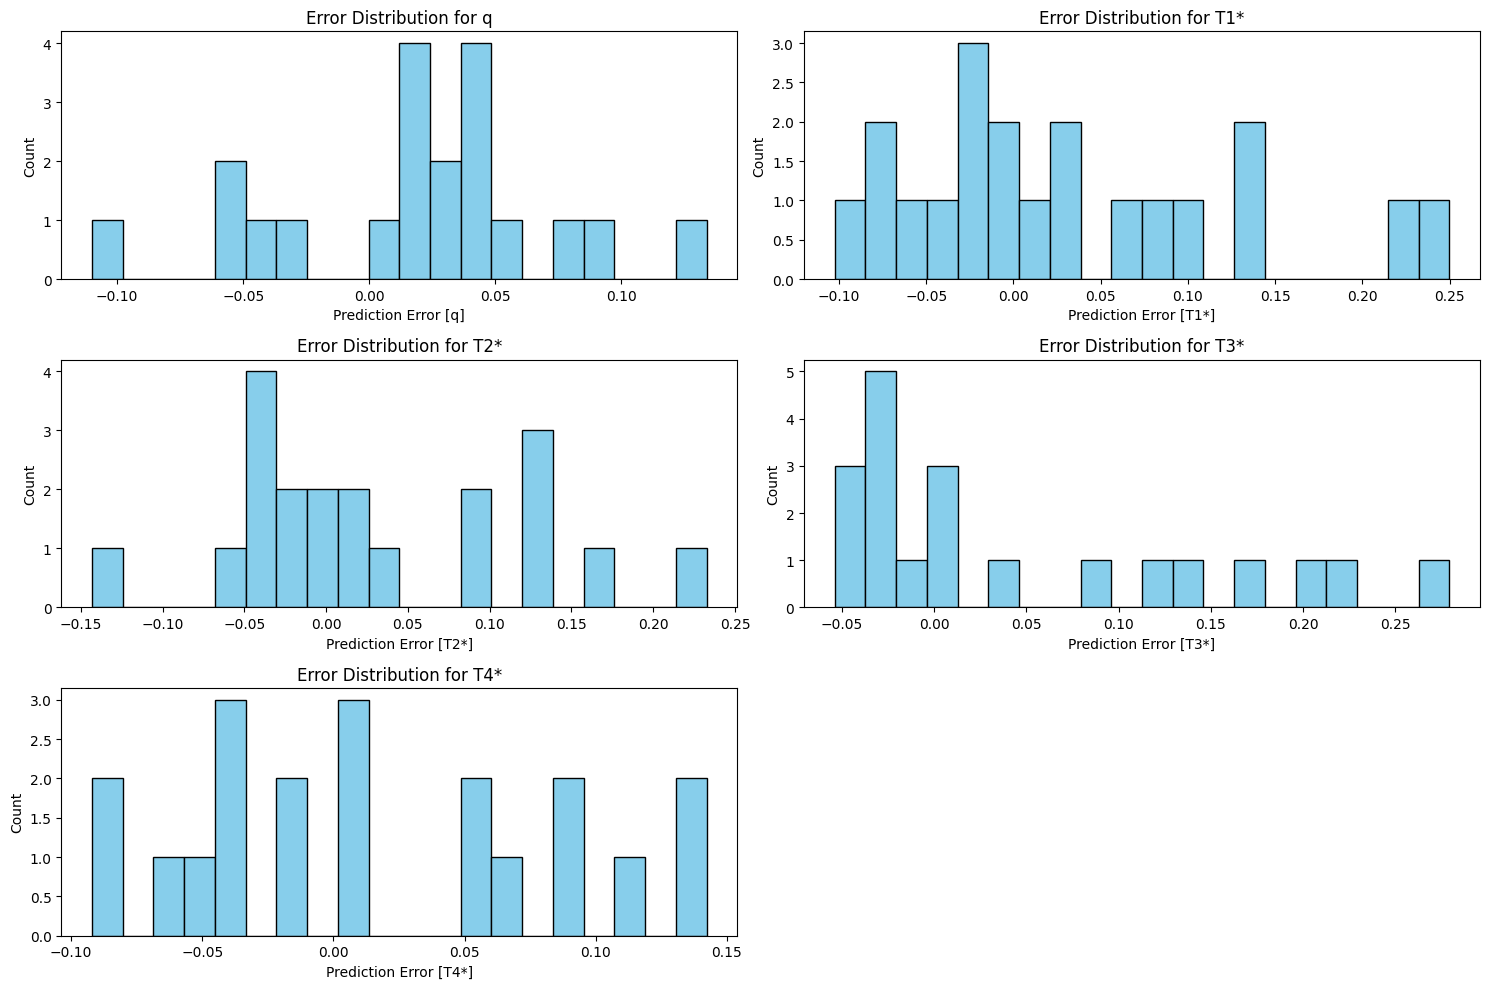

In [ ]:
baseline_error = baseline_test_predictions - test_labels.values
output_names = output_cols

plt.figure(figsize=(15, 10))
for i, name in enumerate(output_names):
    plt.subplot(3, 2, i+1)
    plt.hist(baseline_error[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(f"Prediction Error [{name}]")
    plt.ylabel("Count")
    plt.title(f"Error Distribution for {name}")

plt.tight_layout()
plt.show()